# Data fields

- **Age** – Wiek osoby.
- **Workclass** – Rodzaj pracodawcy, jaki ma dana osoba. Niezależnie od tego, czy są to instytucje rządowe, wojskowe, prywatne i inne.
- **fnlwgt** – Pewna liczba (mało istotna jaka). Będziemy ignorować tę zmienną.
- **Education** – Najwyższy poziom wykształcenia osiągnięty dla tej osoby.
- **Education-Num** – Najwyższy poziom wykształcenia w formie liczbowej.
- **Marital** – Stan cywilny osoby.
- **Occupation** – Wykonywany zawód.
- **Relationship** – Trochę trudniejsze do wytłumaczenia. Zawiera wartości związane z rodziną, takie jak mąż, ojciec itd.
- **Race** – opisy poszczególnych ras człowieka. 
- **Sex** – Płeć.
- **Capital Gain** – Zyski kapitałowe rejestrowane.
- **Capital Loss** – Straty kapitałowe rejestrowane.
- **Hours per week** – Liczba godzin przepracowane w tygodniu.
- **Country** – Kraj pochodzenia danej osoby.
- **Target** – Zmienna logiczna (mniejsza, równa się lub większa). Niezależnie od tego, czy dana osoba zarabia więcej niż 50 000$ rocznie.

# Import libs

In [26]:
import pandas as pd
import numpy as np
import scikitplot as skplt
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

np.random.seed(0)

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

import scikitplot as skplt
from sklearn.linear_model import LogisticRegression

from scikitplot.estimators import plot_learning_curve

import qgrid

%matplotlib inline

# Read Data

In [27]:
df = pd.read_hdf('../Portfolio/train.adult.h5')

# Basic data information

In [28]:
df.shape

(32561, 15)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int8  
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Martial Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  bool  
 10  Capital Gain    32561 non-null  int16 
 11  Capital Loss    32561 non-null  int16 
 12  Hours per week  32561 non-null  int8  
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


# Filling empty data -1

In [30]:
df = df.fillna(-1)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int8  
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Martial Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  bool  
 10  Capital Gain    32561 non-null  int16 
 11  Capital Loss    32561 non-null  int16 
 12  Hours per week  32561 non-null  int8  
 13  Country         32561 non-null  object
 14  Target          32561 non-null  object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


# Functions for model validation

In [32]:
def train_and_predict(model, X, y):
    scores = cross_val_score(model, X, y, cv = 7, scoring = 'accuracy')
    return np.mean(scores), np.std(scores)

In [65]:
def check_models(feats):
    X = df[ feats ] 
    y = df['Target__cat'] 
    
    models = [
        LogisticRegression(solver = 'lbfgs', max_iter = 1001),
        DecisionTreeClassifier(max_depth = 8, random_state = 1),
        RandomForestClassifier(max_depth = 8, n_estimators = 100, random_state = 1),
        ExtraTreesClassifier(max_depth = 8, n_estimators = 100, random_state = 1),
        xgb.XGBClassifier(random_state = 1, n_estimators = 100),
        lgb.LGBMClassifier(n_estimators = 100, random_state = 1),
        ctb.CatBoostClassifier(n_estimators = 100, depth = 10, verbose=False, random_state = 1)
    ]
    
    best = (0, 0, '')
    for model in models:   
        score = train_and_predict(model, X, y)
        
        print("Model: {0},\n Mean: {1} % and Std: {2},".format(model, score[0] * 100, score[1]) )
        if score[0] > best[0]:
            best = (score[0], score[1], model)
    return best

In [60]:
def show_best_model(feats): 
    best = check_models(feats)
    print("Best model is {0},\nGets {1} % and std: {2},".format(best[2], best[0] * 100, best[1]) )

In [154]:
def Best_model_valid(model, feats):
    X = df[ feats ] 
    y = df['Target__cat'] 
    score_mean, score_std = train_and_predict(model, X, y)
    return score_mean * 100, score_std

# Changing target column to number 

In [62]:
df['Target__cat'] = df['Target'].factorize()[0]

# Function for drawing learning plot and showing importance of feats

In [63]:
def check_features(model, feats):
    X = df[feats]
    y = df['Target__cat']
    model.fit(X, y)
    
    skplt.estimators.plot_feature_importances(model, figsize = (15, 6),                                               feature_names = feats, x_tick_rotation = 90 )    
    skplt.estimators.plot_learning_curve(model, X, y, figsize = (15, 6), cv = 7, scoring = 'accuracy')  

# Basic feats 84.29%

In [66]:
basic_feats = list(df.select_dtypes(np.number).columns)[:-1]
print(basic_feats)
show_best_model(basic_feats)

['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']
Model: LogisticRegression(max_iter=1001),
 Mean: 78.39439862215592 % and Std: 0.001760898057947733,
Model: DecisionTreeClassifier(max_depth=8, random_state=1),
 Mean: 83.25605061574527 % and Std: 0.0024628685360613425,
Model: RandomForestClassifier(max_depth=8, random_state=1),
 Mean: 83.54168366289578 % and Std: 0.003571637950684945,
Model: ExtraTreesClassifier(max_depth=8, random_state=1),
 Mean: 81.14310318266863 % and Std: 0.00401106093606489,
Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              ran

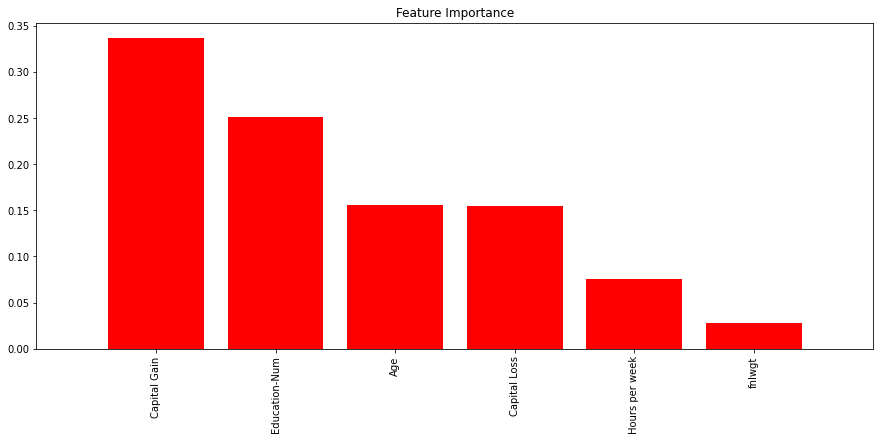

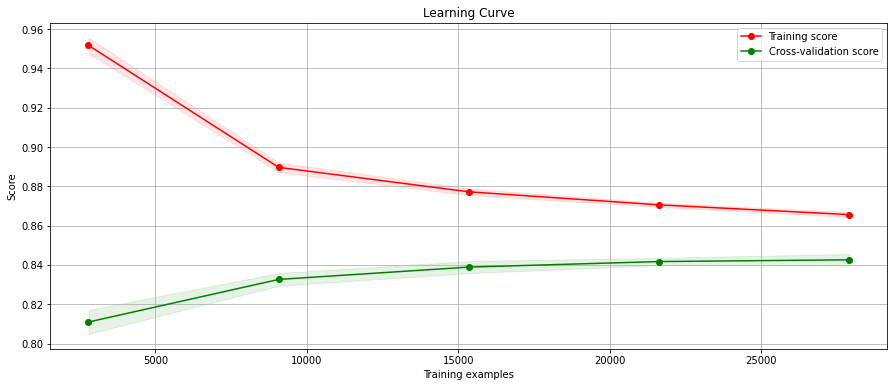

In [68]:
# model = RandomForestClassifier(max_depth=8, random_state=1)
model = xgb.XGBClassifier(random_state = 1, n_estimators = 100)
check_features(model, basic_feats)

# Features Engineering Best -> 87.41%

## Changing categorial feats to number 87.13%

In [69]:
feats_number = list(df.select_dtypes(np.number).columns)[:-1]
feats_number

['Age',
 'fnlwgt',
 'Education-Num',
 'Capital Gain',
 'Capital Loss',
 'Hours per week']

In [70]:
all_feats = feats_number
SUF = '__cat'

for feat in df.columns.values:
#     print(feat)
    if feats_number.count(feat) == 0 and 'Target' not in feat and '__cat' not in feat and 'Education' not in feat:
        df[feat + SUF] = df[feat].factorize()[0]
        all_feats.append(feat + SUF)

In [71]:
print(all_feats)
show_best_model(all_feats)

['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Workclass__cat', 'Martial Status__cat', 'Occupation__cat', 'Relationship__cat', 'Race__cat', 'Sex__cat', 'Country__cat']
Model: LogisticRegression(max_iter=1001),
 Mean: 78.34832360024383 % and Std: 0.0013090761623327253,
Model: DecisionTreeClassifier(max_depth=8, random_state=1),
 Mean: 85.45502284755375 % and Std: 0.004822119845719082,
Model: RandomForestClassifier(max_depth=8, random_state=1),
 Mean: 85.51643838304518 % and Std: 0.0045454463351101825,
Model: ExtraTreesClassifier(max_depth=8, random_state=1),
 Mean: 82.58653168141564 % and Std: 0.0035802446181664735,
Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, m

## Same feats but better parameters 87.31%

In [141]:
#  RandomForestClassifier
params_RF = {
    'max_depth': 16, 
    'n_estimators': 200,
    'random_state': 1
    }
model = RandomForestClassifier(**params_RF)
Best_model_vali(model, all_feats)

(86.44085585619253, 0.0045778624992031695)

In [137]:
# XGBClassifier
params = {
    'n_estimators': 70,
    'random_state': 1,
    'learning_rate': 0.19
    }
model = xgb.XGBClassifier(**params)
Best_model_valid(model, all_feats)

(87.31305787632306, 0.0027784863566216226)

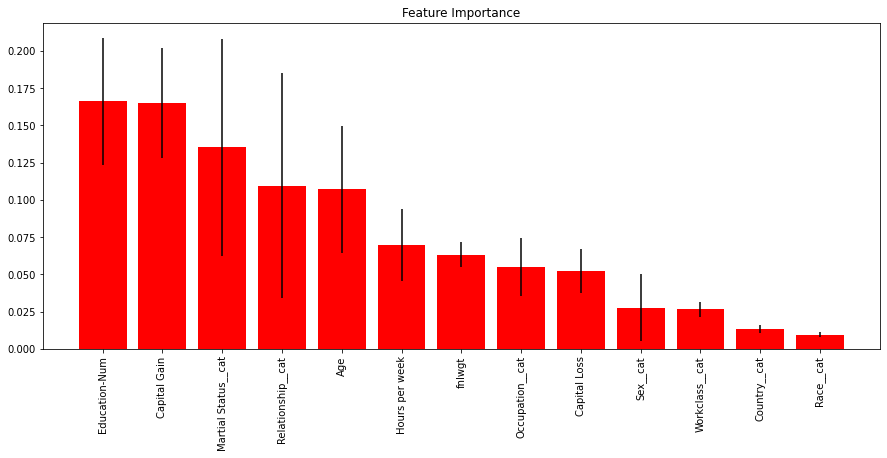

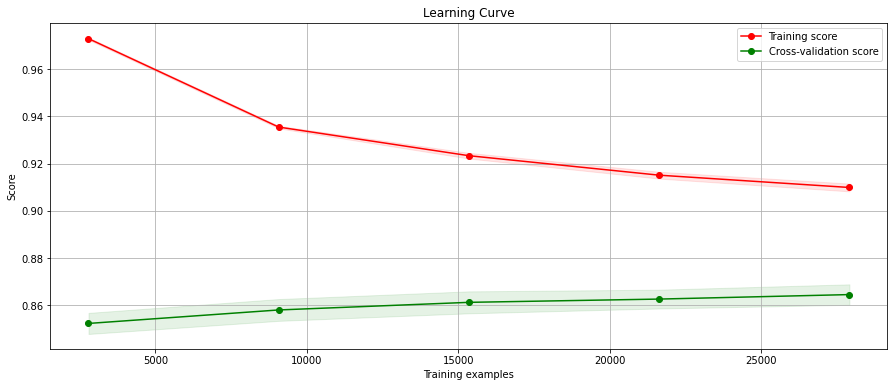

In [131]:
check_features(RandomForestClassifier(**params), all_feats)

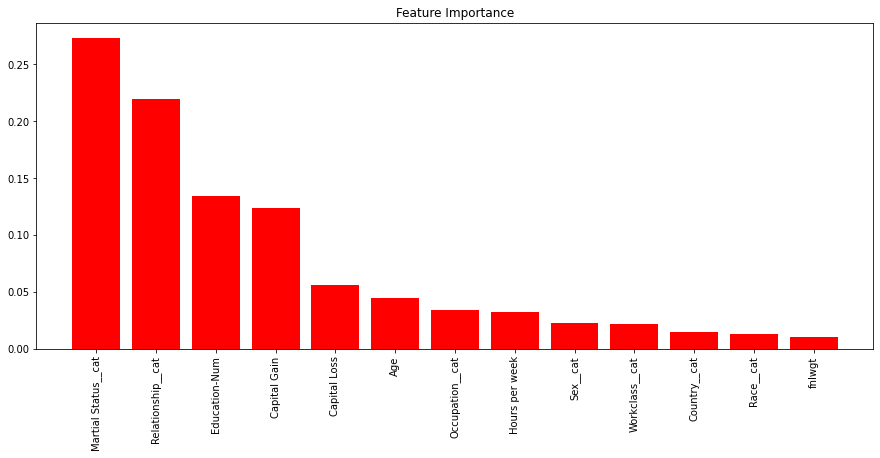

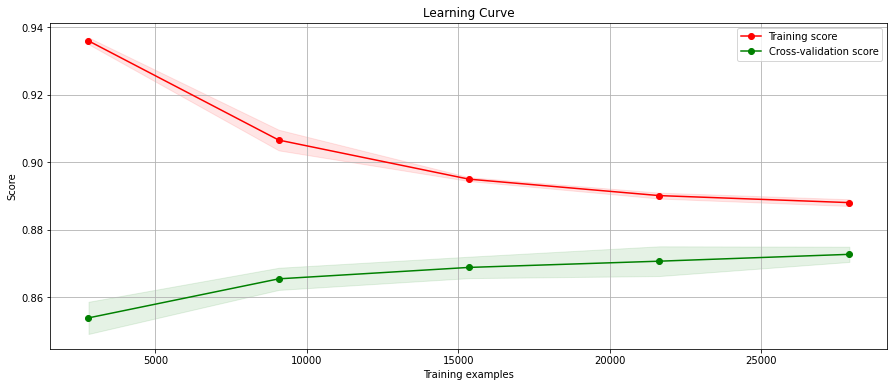

In [146]:
check_features(xgb.XGBClassifier(**params), all_feats)

## New feat 87.41%

In [147]:
df['Summary of Capital'] = df['Capital Gain'] + df['Capital Loss']

In [148]:
new_feats = all_feats
new_feats.append('Summary of Capital')

In [149]:
new_feats

['Age',
 'fnlwgt',
 'Education-Num',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Workclass__cat',
 'Martial Status__cat',
 'Occupation__cat',
 'Relationship__cat',
 'Race__cat',
 'Sex__cat',
 'Country__cat',
 'Summary of Capital']

In [155]:
show_best_model(new_feats)

Model: LogisticRegression(max_iter=1001),
 Mean: 78.27769279626543 % and Std: 0.0027370808220829423,
Model: DecisionTreeClassifier(max_depth=8, random_state=1),
 Mean: 85.43967044926906 % and Std: 0.004850957012340822,
Model: RandomForestClassifier(max_depth=8, random_state=1),
 Mean: 85.7221963062283 % and Std: 0.00424162876429775,
Model: ExtraTreesClassifier(max_depth=8, random_state=1),
 Mean: 83.26219434815705 % and Std: 0.0029799097559233575,
Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=1, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, su

In [256]:
params_v3 = {
    'max_depth': 10,
    'n_estimators':100,
    'random_state': 1,
    'learning_rate': 0.12
    }
model = lgb.LGBMClassifier(**params_v3)
Best_model_valid(model, new_feats)

(87.4144132847131, 0.00314003734613033)

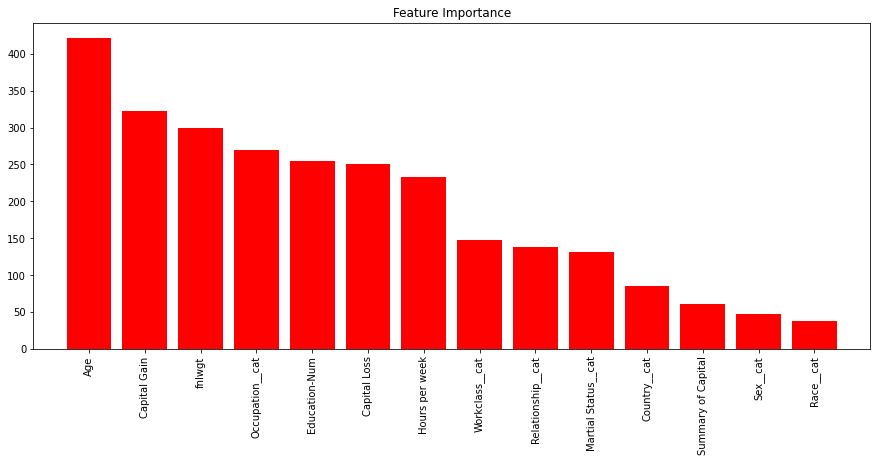

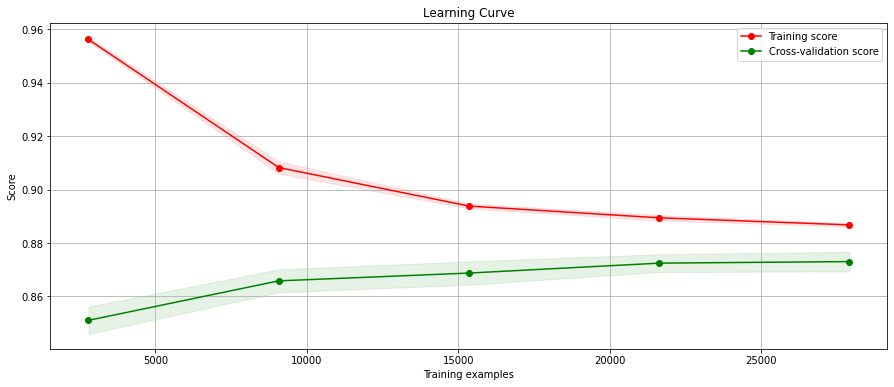

In [205]:
check_features(lgb.LGBMClassifier(**params_v3), all_feats)